# CREATE BASIC GRIDS

This code is made for calculate the flow accumulation and flow direction grid files. To use it you will need a DEM file and install pysheds library.

In this code, the Ghana high resolution grid files will be generated as example.

Author: Vanessa Robledo (vrobledodelgado@uiowa.edu) 

In [2]:
!pip install pysheds


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 172.3 MB/s eta 0:00:0000:01
  Created wheel for pysheds: filename=pysheds-0.4-py3-none-any.whl size=90689 sha256=f3e36bd144670e28afe381498b633d69ddabbb6dde0f5f4c434b5624fcac2d04
  Stored in directory: /home/vrobledodelgado/.cache/pip/wheels/a1/71/eb/89f783658494ca6676dd77fc1b54090a1b748f0055cea65f1c
Successfully built pysheds

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import pysheds
from pysheds.grid import Grid
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio

"""
Para usar este codigo, me toca primero calcular el FLowACC y flow dir del dem completo de AFRICA,
o recortarlo con un cuadrado y ya luego si usar las librerias y por ultimo pasar los resultados por el 
otro codigo que los cortaria para ghana y los dejaria en la version que se necesitan.

"""

'\nPara usar este codigo, me toca primero calcular el FLowACC y flow dir del dem completo de AFRICA,\no recortarlo con un cuadrado y ya luego si usar las librerias y por ultimo pasar los resultados por el \notro codigo que los cortaria para ghana y los dejaria en la version que se necesitan.\n\n'

### Download DEM and clip it using coords

In [72]:
!wget https://data.hydrosheds.org/file/hydrosheds-v1-dir/af_dir_3s.zip
!unzip af_dir_3s.zip -d hyd_af_dir

--2025-02-11 14:04:33--  https://data.hydrosheds.org/file/hydrosheds-v1-dir/af_dir_3s.zip
Connecting to 192.168.64.17:3128... connected.
Proxy request sent, awaiting response... 200 
Length: 1321423239 (1.2G) [application/zip]
Saving to: ‘af_dir_3s.zip’

af_dir_3s.zip       100%[===================>]   1.23G  40.4MB/s    in 31s     

2025-02-11 14:05:05 (40.2 MB/s) - ‘af_dir_3s.zip’ saved [1321423239/1321423239]

Archive:  af_dir_3s.zip
 extracting: hyd_af_dir/af_dir_3s.tif  
 extracting: hyd_af_dir/HydroSHEDS_TechDoc_v1_4.pdf  


In [5]:
## Get the 90m DEM 
!wget https://data.hydrosheds.org/file/hydrosheds-v1-dem/af_dem_3s.zip
!unzip af_dem_3s.zip -d hyd_af_dem

--2025-02-11 08:32:20--  https://data.hydrosheds.org/file/hydrosheds-v1-dem/af_dem_3s.zip
Connecting to 192.168.64.17:3128... connected.
Proxy request sent, awaiting response... 200 
Length: 3524608023 (3.3G) [application/zip]
Saving to: ‘af_dem_3s.zip’

af_dem_3s.zip       100%[===================>]   3.28G  46.6MB/s    in 78s     

2025-02-11 08:33:39 (43.2 MB/s) - ‘af_dem_3s.zip’ saved [3524608023/3524608023]

Archive:  af_dem_3s.zip
 extracting: hyd_af_dem/af_dem_3s.tif  
 extracting: hyd_af_dem/HydroSHEDS_TechDoc_v1_4.pdf  


In [74]:
!wget https://data.hydrosheds.org/file/hydrosheds-v1-acc/af_acc_3s.zip
!unzip af_acc_3s.zip -d hyd_af_acc

Archive:  af_acc_3s.zip
 extracting: hyd_af_acc/af_acc_3s.tif   (warning) cannot set modif./access times
          No such file or directory
error:  cannot create hyd_af_acc/HydroSHEDS_TechDoc_v1_4.pdf
        No such file or directory


Process the DEM using gdal: usign coordinates lat lon, clip the rasterfile

In [75]:
xmin = -7
xmax = 3.5
ymin = 4
ymax = 16

def ClipRaster(gridFile, xmin, ymin, xmax, ymax, gridOutName):
    # Open the input raster file
    rawGridIn = gdal.Open(gridFile, gdal.GA_ReadOnly)
    if rawGridIn is None:
        raise Exception(f"Failed to open the input raster file: {gridFile}")

    # Clip the raster to the specified extent
    clipped_ds = gdal.Warp(
        gridOutName,
        rawGridIn,
        format='GTiff',
        outputBounds=(xmin, ymin, xmax, ymax),
        dstNodata=-9999.0,  # Set a temporary NoData value
        outputType=gdal.GDT_Float32  # Ensure output is in Float32
    )

    if clipped_ds is None:
        raise Exception("Failed to clip the raster.")

    # # Read the clipped raster as a NumPy array
    # clipped_array = clipped_ds.GetRasterBand(1).ReadAsArray()

    # # Replace the temporary NoData value with NaN
    # clipped_array[clipped_array == -9999.0] = np.nan

    # # Write the modified array back to the output file
    # driver = gdal.GetDriverByName('GTiff')
    # dst_ds = driver.Create(gridOutName, clipped_ds.RasterXSize, clipped_ds.RasterYSize, 1, gdal.GDT_Float32)
    # dst_ds.SetGeoTransform(clipped_ds.GetGeoTransform())
    # dst_ds.SetProjection(clipped_ds.GetProjection())
    # dst_ds.GetRasterBand(1).WriteArray(clipped_array)
    # dst_ds.GetRasterBand(1).SetNoDataValue(np.nan)  # Set NoData to NaN (though this won't work directly)
    # dst_ds.FlushCache()  # Ensure data is written to disk

    # Close the datasets
    rawGridIn = None
    clipped_ds = None
    # dst_ds = None

In [ ]:
gridFile = '/home/vrobledodelgado/hpchome/SERVIR/GhanaEF5_90m/gis/hyd_af_dem/af_dem_3s.tif'
gridOutName = '/home/vrobledodelgado/hpchome/SERVIR/GhanaEF5_90m/gis/2hydro_DEM_ghana.tif'
# Call the function to clip the raster
ClipRaster(gridFile, xmin, ymin, xmax, ymax, gridOutName)

In [76]:
gridFile = '/home/vrobledodelgado/hpchome/SERVIR/GhanaEF5_90m/gis/hyd_af_acc/af_acc_3s.tif'
gridOutName = '/home/vrobledodelgado/hpchome/SERVIR/GhanaEF5_90m/gis/hydro_ACC_ghana.tif'
# Call the function to clip the raster
ClipRaster(gridFile, xmin, ymin, xmax, ymax, gridOutName)

In [77]:
gridFile = '/home/vrobledodelgado/hpchome/SERVIR/GhanaEF5_90m/gis/hyd_af_dir/af_dir_3s.tif'
gridOutName = '/home/vrobledodelgado/hpchome/SERVIR/GhanaEF5_90m/gis/hydro_DIR_ghana.tif'
# Call the function to clip the raster
ClipRaster(gridFile, xmin, ymin, xmax, ymax, gridOutName)

## Using Pysteps to create FAC and FDIR 

In [86]:
#read dem 
fn = "/home/vrobledodelgado/hpchome/SERVIR/GhanaEF5_90m/basic_files/DEM_ghana90m.tif"
grid = Grid.from_raster(fn)
dem = grid.read_raster(fn)
dem[dem == -9999] = np.nan

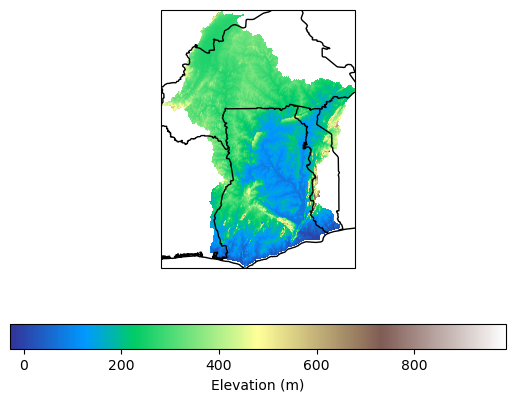

In [87]:
#visualize it 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.imshow(dem, extent=grid.extent, cmap="terrain")
plt.colorbar(label="Elevation (m)", orientation="horizontal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

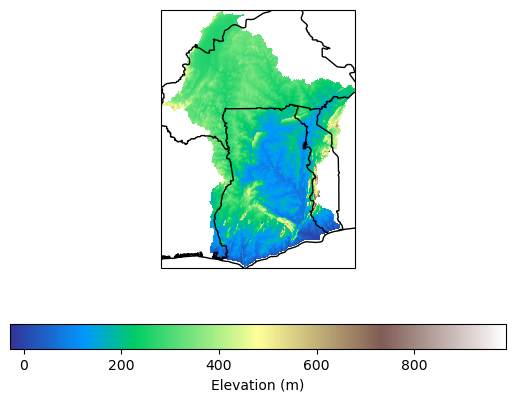

In [88]:
#conditioning elevation data
# In this case we do not have to do this process because  hydrosheds at 90m is already conditioned 
pit_filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(pit_filled_dem)
conditioned_dem = grid.resolve_flats(dem)
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.imshow(conditioned_dem, extent=grid.extent, cmap="terrain")
plt.colorbar(label="Elevation (m)", orientation="horizontal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

In [89]:
#computing flow direction
#dem[dem == -9999] = np.nan
flowdir = grid.flowdir(conditioned_dem)
flowdir.nodata = 0

#flowdir

TypeError: `nodata` value not representable in dtype of array.

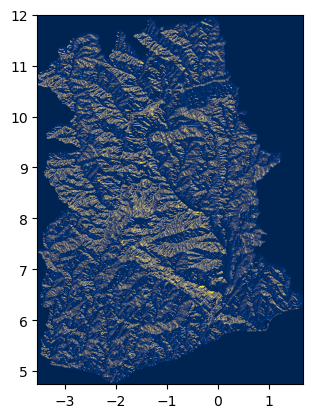

In [45]:
plt.imshow(flowdir, extent=grid.extent, cmap="cividis")

In [46]:
acc = grid.accumulation(flowdir)

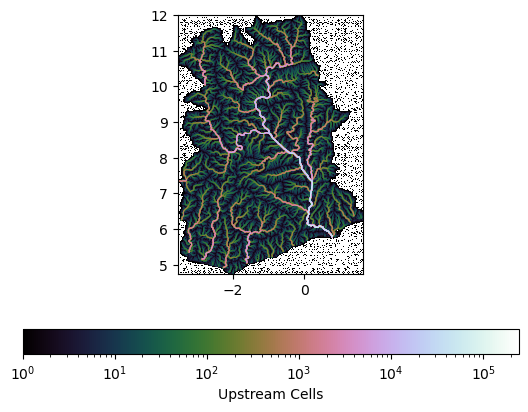

In [47]:
fig, ax = plt.subplots()
im = ax.imshow(
    acc,
    extent=grid.extent,
    cmap="cubehelix",
    norm=LogNorm(1, acc.max()),
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Upstream Cells", orientation="horizontal")

In [33]:
dem

Raster([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)